# Guest Count Predictor

We will use machine learning algorithms for predicting the true `guest_count` for table orders.

As the company states, just about 30% of the tables report a **true** ("trustworthy") `guest_count` values.  
Well, what about the rest? It is unusable.

---

Measure notebook run time:

In [1]:
import time
from datetime import timedelta

start = time.time()

---

Load the whole dataset, then, split to DEV (+ VALID) and TEST sets according to the bar filtration schema we've written in the *pre-processing* scripts.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_map_tables = {
    "hockey"    : "../data/hockey_textual_n_features_processed_tables.csv",
    "valentine" : "../data/valentine_textual_n_features_processed_tables.csv",
    "silvester" : "../data/silvester_textual_n_features_processed_tables.csv"
}

In [5]:
columns = [
    "bar_id",
    "order_id",
    #"order_time",
    #"order_time_closed",
    "order_hour",
    #"order_minute",
    "order_close_hour",
    #"order_close_minute",
    "period_of_day",
    "order_day_of_week",
    "is_weekend",
    "item_qty",
    "beer_volume",
    "guest_count",
    "total_orders_category_id_1.0",
    "total_orders_category_id_2.0",
    "total_orders_category_id_3.0",
    "total_orders_category_id_4.0",
    "total_orders_category_id_5.0",
    "total_orders_category_id_6.0",
    "total_orders",
    "total_large_meals",
    "total_small_meals",
    "total_large_sharable_meals",
    "total_small_sharable_meals",
    "sharable",
    "kids_meal",
    "birthday",
    "dwell_time",
    "meal_flow_last_to_close",
    "total_flow_steps",
    "total_meal_steps",
    "avg_time_between_steps",
    "sit_to_order",
    "max_items_per_step",
    "total_sales_before_tax"#,
    #"total_sales_inc_tax"
]

In [6]:
df = {}

for table in data_map_tables.keys():
    df[table] = pd.read_csv(data_map_tables[table], usecols=columns)

df = pd.concat([df[table] for table in data_map_tables.keys()])

In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
print(df.shape)

(277587, 32)


## Handle Features

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277587 entries, 0 to 277586
Data columns (total 32 columns):
order_id                        277587 non-null int64
bar_id                          277587 non-null int64
order_hour                      277587 non-null int64
order_close_hour                277587 non-null int64
period_of_day                   277587 non-null object
order_day_of_week               277587 non-null object
is_weekend                      277587 non-null bool
item_qty                        277587 non-null float64
beer_volume                     277587 non-null float64
guest_count                     277587 non-null int64
total_orders_category_id_1.0    277587 non-null float64
total_orders_category_id_2.0    277587 non-null float64
total_orders_category_id_3.0    277587 non-null float64
total_orders_category_id_4.0    277587 non-null float64
total_orders_category_id_5.0    277587 non-null float64
total_orders_category_id_6.0    277587 non-null float64
total_or

In [10]:
df.head()

,order_id,bar_id,order_hour,order_close_hour,period_of_day,order_day_of_week,is_weekend,item_qty,beer_volume,guest_count,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0,total_orders,total_large_meals,total_small_meals,total_large_sharable_meals,total_small_sharable_meals,sharable,kids_meal,birthday,dwell_time,meal_flow_last_to_close,total_flow_steps,total_meal_steps,avg_time_between_steps,sit_to_order,max_items_per_step,total_sales_before_tax
0,510834245,7127,0,1,night,Wednesday,False,1.0,0.000,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0.630833,9,9,1,1.0,1,1,7.75
1,510839657,17271,0,0,night,Wednesday,False,2.0,0.828,2,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0.612778,9,9,1,1.0,1,2,15.00
2,510839665,17271,0,1,night,Wednesday,False,2.0,0.000,1,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0,0,0,0.880000,12,12,1,1.0,1,2,18.95
3,510839666,17271,0,0,night,Wednesday,False,2.0,0.828,1,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0.424444,0,5,2,10.5,1,1,11.90
4,510839684,17271,0,1,night,Wednesday,False,1.0,0.000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0.782778,11,11,1,1.0,1,1,13.00


### Features
All non-depicted features are continuous (/integers).

- `order_id` - DROP
- `bar_id` - DROP
- `order_hour` - Cyclical Feature
- `order_close_hour` - Cyclical Feature
- `period_of_day` - Cyclical Feature
- `order_day_of_week` - Cyclical Feature
- `is_weekend` - Binary Feature
- `item_qty`
- `beer_volume`
- `guest_count`
- `total_orders_category_id_1.0`
- `total_orders_category_id_2.0`
- `total_orders_category_id_3.0`
- `total_orders_category_id_4.0`
- `total_orders_category_id_5.0`
- `total_orders_category_id_6.0`
- `total_orders`
- `total_large_meals`
- `total_small_meals`
- `total_large_sharable_meals`
- `total_small_sharable_meals`
- `sharable` - Binary Feature
- `kids_meal` - Binary Feature
- `birthday` - Binary Feature
- `dwell_time`
- `meal_flow_last_to_close`
- `total_flow_steps`
- `total_meal_steps`
- `avg_time_between_steps`
- `sit_to_order`
- `max_items_per_step`
- `total_sales_before_tax` 

*To sum up*:

**Cyclical Features**: `order_hour`, `order_close_hour`, `period_of_day`, `order_day_of_week`

**Binary Features**: `is_weekend`, `sharable`, `kids_meal`, `birthday`

### Handle Cyclical Features

Hours of the day, days of the week.
We should convert these features into a representation that can preserve information such as hour 23 and hour 0 being close to each other and not far.

We are going to calculate the sin and cos component so that the cyclical feature will be represented as (x,y) coordinates of a circle. In this representation hour, 23 and hour 0 are right next to each other numerically, just as they should be.

**order_hour**

In [11]:
df['order_hour_sin'] = np.sin(df.order_hour * (2. * np.pi/24))
df['order_hour_cos'] = np.cos(df.order_hour * (2. * np.pi/24))

In [12]:
df = df.drop(['order_hour'], axis=1)

**order_close_hour**

In [13]:
df['order_close_hour_sin'] = np.sin(df.order_close_hour * (2. * np.pi/24))
df['order_close_hour_cos'] = np.cos(df.order_close_hour * (2. * np.pi/24))

In [14]:
df = df.drop(['order_close_hour'], axis=1)

Map *string* features to *integers*:

In [15]:
print(df.period_of_day.unique())

['night' 'breakfast' 'lunch' 'afternoon' 'dinner' 'hang_out']


In [16]:
periods_of_day = ['breakfast', 'lunch', 'afternoon', 'dinner', 'hang_out', 'night']
pod2idx = {period: idx for idx, period in enumerate(periods_of_day)}

In [17]:
pod2idx

{'breakfast': 0,
 'lunch': 1,
 'afternoon': 2,
 'dinner': 3,
 'hang_out': 4,
 'night': 5}

In [18]:
print(df.order_day_of_week.unique())

['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']


In [19]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
odow2idx = {day: idx for idx, day in enumerate(days_of_week)}

In [20]:
odow2idx

{'Monday': 0,
 'Tuesday': 1,
 'Wednesday': 2,
 'Thursday': 3,
 'Friday': 4,
 'Saturday': 5,
 'Sunday': 6}

**period_of_day**

In [21]:
df['period_of_day_int'] = df['period_of_day'].apply(lambda period_of_day: pod2idx[period_of_day])

In [22]:
df['period_of_day_sin'] = np.sin(df.period_of_day_int * (2. * np.pi/6))
df['period_of_day_cos'] = np.cos(df.period_of_day_int * (2. * np.pi/6))

In [23]:
df = df.drop(['period_of_day', 'period_of_day_int'], axis=1)

**order_day_of_week**

In [24]:
df['order_day_of_week_int'] = df['order_day_of_week'].apply(lambda order_day_of_week: odow2idx[order_day_of_week])

In [25]:
df['order_day_of_week_sin'] = np.sin(df.order_day_of_week_int * (2. * np.pi/6))
df['order_day_of_week_cos'] = np.cos(df.order_day_of_week_int * (2. * np.pi/6))

In [26]:
df = df.drop(['order_day_of_week', 'order_day_of_week_int'], axis=1)

### Handle Binary Features

Binarize the `is_weekend` feature (*True*/*False* -> *1*/*0*).

In [27]:
df['is_weekend']

0         False
1         False
2         False
3         False
4         False
          ...  
277582     True
277583     True
277584     True
277585     True
277586     True
Name: is_weekend, Length: 277587, dtype: bool

In [28]:
df['is_weekend'] = df['is_weekend'].apply(lambda boolean: int(boolean))

In [29]:
df['is_weekend']

0         0
1         0
2         0
3         0
4         0
         ..
277582    1
277583    1
277584    1
277585    1
277586    1
Name: is_weekend, Length: 277587, dtype: int64

----

Check out current features:

In [30]:
df.head()

,order_id,bar_id,is_weekend,item_qty,beer_volume,guest_count,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0,total_orders,total_large_meals,total_small_meals,total_large_sharable_meals,total_small_sharable_meals,sharable,kids_meal,birthday,dwell_time,meal_flow_last_to_close,total_flow_steps,total_meal_steps,avg_time_between_steps,sit_to_order,max_items_per_step,total_sales_before_tax,order_hour_sin,order_hour_cos,order_close_hour_sin,order_close_hour_cos,period_of_day_sin,period_of_day_cos,order_day_of_week_sin,order_day_of_week_cos
0,510834245,7127,0,1.0,0.000,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0.630833,9,9,1,1.0,1,1,7.75,0.0,1.0,0.258819,0.965926,-0.866025,0.5,0.866025,-0.5
1,510839657,17271,0,2.0,0.828,2,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0.612778,9,9,1,1.0,1,2,15.00,0.0,1.0,0.000000,1.000000,-0.866025,0.5,0.866025,-0.5
2,510839665,17271,0,2.0,0.000,1,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0,0,0,0.880000,12,12,1,1.0,1,2,18.95,0.0,1.0,0.258819,0.965926,-0.866025,0.5,0.866025,-0.5
3,510839666,17271,0,2.0,0.828,1,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0.424444,0,5,2,10.5,1,1,11.90,0.0,1.0,0.000000,1.000000,-0.866025,0.5,0.866025,-0.5
4,510839684,17271,0,1.0,0.000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0.782778,11,11,1,1.0,1,1,13.00,0.0,1.0,0.258819,0.965926,-0.866025,0.5,0.866025,-0.5


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277587 entries, 0 to 277586
Data columns (total 36 columns):
order_id                        277587 non-null int64
bar_id                          277587 non-null int64
is_weekend                      277587 non-null int64
item_qty                        277587 non-null float64
beer_volume                     277587 non-null float64
guest_count                     277587 non-null int64
total_orders_category_id_1.0    277587 non-null float64
total_orders_category_id_2.0    277587 non-null float64
total_orders_category_id_3.0    277587 non-null float64
total_orders_category_id_4.0    277587 non-null float64
total_orders_category_id_5.0    277587 non-null float64
total_orders_category_id_6.0    277587 non-null float64
total_orders                    277587 non-null float64
total_large_meals               277587 non-null float64
total_small_meals               277587 non-null float64
total_large_sharable_meals      277587 non-null float64
t

-----

## Bars Filtration

In [32]:
df_good = df[~(df.total_sales_before_tax == 0)]

bars = df.bar_id.unique()
features = ['bar_id', 'guest_count']
tables = df.drop_duplicates(subset='order_id', keep='first')
tables.set_index('order_id', inplace=True)
tables = tables[features]

desc = tables.groupby('bar_id').guest_count.describe()
desc_columns = ['guest_count_count', 'guest_count_mean', 'guest_count_std', 'guest_count_min', \
                'guest_count_25%', 'guest_count_50%', 'guest_count_75%', 'guest_count_max']
desc.columns = desc_columns

tables = tables.reset_index().merge(desc, on='bar_id').set_index(tables.index).drop(['order_id'], axis=1)

bars_data = tables.drop_duplicates(subset='bar_id', keep='first')[['bar_id'] + desc_columns]
bars_data.set_index('bar_id', inplace=True)
bars_data = bars_data[(bars_data.guest_count_max != 0) & (bars_data.guest_count_max != 1)]

last_bars = bars_data[bars_data["guest_count_min"] != 0]
if len(last_bars) < 25:
    df_good = df_good[df_good.bar_id.isin(bars_data.index)]
else:
    df_good = df_good[df_good.bar_id.isin(last_bars.index)]

##### Drop any table with `guest_count` < 1

In [33]:
df_good = df_good[df_good.guest_count >= 1]

##### TODO: figure out how to filter extra tables (the existing logic is too forgiving)

---

Take a look at the `guest_count` feature distribution:

In [34]:
df_good.guest_count.value_counts()

1      96845
2      56583
3      18333
4      10399
5       4010
6       2131
7       1001
8        628
9        417
10       260
11       156
12       115
13        95
14        60
15        44
18        31
16        28
17        28
19        27
20        19
21        18
22        16
24        13
23         9
25         7
26         7
32         5
27         4
28         3
30         3
35         3
55         2
29         2
33         2
52         2
37         2
78         1
180        1
60         1
58         1
46         1
48         1
39         1
45         1
43         1
42         1
40         1
38         1
34         1
108        1
Name: guest_count, dtype: int64

In [35]:
df_good.guest_count.value_counts(normalize=True)

1      0.506189
2      0.295747
3      0.095823
4      0.054353
5      0.020959
6      0.011138
7      0.005232
8      0.003282
9      0.002180
10     0.001359
11     0.000815
12     0.000601
13     0.000497
14     0.000314
15     0.000230
18     0.000162
16     0.000146
17     0.000146
19     0.000141
20     0.000099
21     0.000094
22     0.000084
24     0.000068
23     0.000047
25     0.000037
26     0.000037
32     0.000026
27     0.000021
28     0.000016
30     0.000016
35     0.000016
55     0.000010
29     0.000010
33     0.000010
52     0.000010
37     0.000010
78     0.000005
180    0.000005
60     0.000005
58     0.000005
46     0.000005
48     0.000005
39     0.000005
45     0.000005
43     0.000005
42     0.000005
40     0.000005
38     0.000005
34     0.000005
108    0.000005
Name: guest_count, dtype: float64

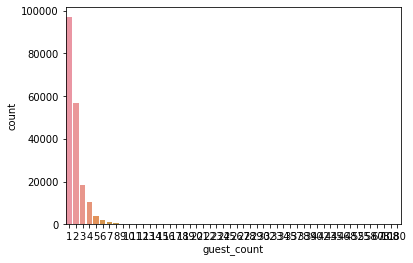

In [36]:
sns.countplot(x="guest_count", data=df_good)

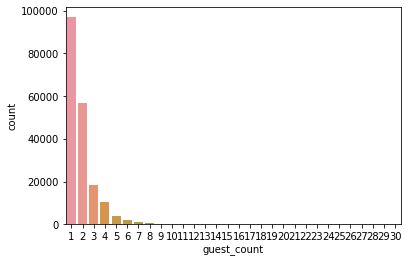

In [37]:
sns.countplot(x="guest_count", data=df_good[df_good.guest_count <= 30])

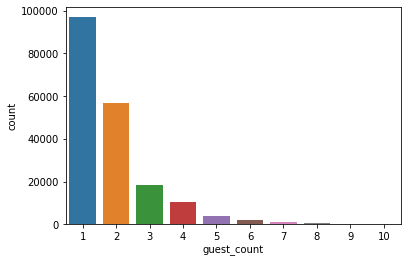

In [38]:
sns.countplot(x="guest_count", data=df_good[df_good.guest_count <= 10])

Now, using bins:

In [39]:
def map_gc_bin(guest_count):
    if guest_count == 1:
        return '1'
    elif guest_count == 2:
        return '2'
    elif guest_count >= 3 and guest_count <= 5:
        return '3-5'
    elif guest_count >= 6:
        return '6+'
    
    raise ValueError('An unexpected value occurred')

In [40]:
df_good['guest_count_bin'] = df_good.apply(lambda table: map_gc_bin(table.guest_count), axis=1)

In [41]:
df_good.guest_count_bin.value_counts()

1      96845
2      56583
3-5    32742
6+      5152
Name: guest_count_bin, dtype: int64

In [42]:
df_good.guest_count_bin.value_counts(normalize=True)

1      0.506189
2      0.295747
3-5    0.171136
6+     0.026928
Name: guest_count_bin, dtype: float64

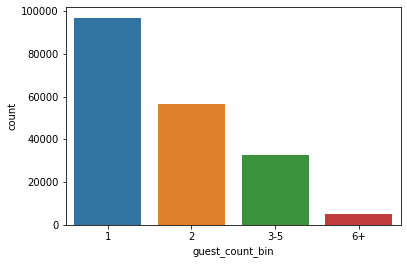

In [43]:
sns.countplot(x="guest_count_bin", data=df_good)

In [44]:
df_good.drop(['guest_count_bin'], axis=1, inplace=True)

----

In [45]:
df_bad = df[~(df.order_id.isin(df_good.order_id.values))]

In [46]:
df = df.drop(['bar_id'], axis=1)
df_good = df_good.drop(['bar_id'], axis=1)
df_bad = df_bad.drop(['bar_id'], axis=1)

In [47]:
assert(len(df) == len(df_good) + len(df_bad))

In [48]:
print("Size of trustworthy guest_count orders: ", len(df_good))

Size of trustworthy guest_count orders:  191322


We'll use these orders for train (DEV + VALID sets) + test (TEST set)

In [49]:
print("Size of untrustworthy guest_count orders: ", len(df_bad))

Size of untrustworthy guest_count orders:  86265


We'll not perform our prediction for these orders.

----

Pick **good** entries:

In [50]:
df_orig = df
df = df_good

---

## Machine Learning

This is a classification problem, a table can get any integer value for `guest_count` starting from 1.

This is a **regression** task.  
Note we will have to round the results to integer values (typeof `guest_count` == int)

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X = df.drop(['order_id', 'guest_count'], axis=1)

In [53]:
y = df['guest_count']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [55]:
truths = list(y_test.values)

In [56]:
bins = ['1', '2', '3-5', '6+']

In [57]:
def bin_it(label):
    if label == 1:
        return 0
    elif label == 2:
        return 1
    elif label >= 3 and label <= 5:
        return 2
    elif label >= 6:
        return 3
    
    raise ValueError('An unexpected value occurred')

In [58]:
def bin_them(labels):
    return [bin_it(label) for label in labels]

In [59]:
def measure_bin(trues, preds, bin_idx):
    trues_idx = np.where(trues == bin_idx)
    preds_idx = np.where(preds == bin_idx)
    
    recall = sum(preds[trues_idx] == bin_idx) / len(trues_idx[0])
    precision = sum(trues[preds_idx] == bin_idx) / len(preds_idx[0])

    print("\tMeasuring performance for bin {}".format(bins[bin_idx]))
    print("\t\tRecall = {:.2f}".format(recall))
    print("\t\tPrecision = {:.2f}".format(precision))

In [60]:
def measure_performance(model_name, trues, preds):
    trues, preds = bin_them(trues), bin_them(preds)
    trues, preds = np.array(trues), np.array(preds)
    print("Measuring performance (recall + precision) for the {} model".format(model_name))
    
    for bin_idx in range(len(bins)):
        measure_bin(trues, preds, bin_idx)

---

### Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor

In [62]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=5)

In [63]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [64]:
tree_preds = tree.predict(X_test)

In [65]:
tree_preds[:20]

array([2.39166556, 3.22749376, 1.17081383, 1.17081383, 1.17081383,
       1.79531469, 4.92556054, 1.79531469, 1.17081383, 2.39166556,
       1.79531469, 1.79531469, 1.17081383, 1.17081383, 1.17081383,
       1.78481502, 2.39166556, 1.17081383, 1.17081383, 1.78481502])

In [66]:
tree_preds = [int(round(pred)) for pred in tree_preds]

DT Preds:

In [67]:
tree_preds[:20]

[2, 3, 1, 1, 1, 2, 5, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2]

Truths:

In [68]:
truths[:20]

[2, 2, 1, 2, 1, 3, 6, 1, 1, 4, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2]

In [69]:
comp = [true_pred == tree_pred for true_pred, tree_pred in zip(truths, tree_preds)]

In [70]:
acc = sum(comp) / len(y_test)
print("Accuracy for model: {:.2%}".format(acc))

Accuracy for model: 64.12%


In [71]:
measure_performance('decision-tree', truths, tree_preds)

Measuring performance (recall + precision) for the decision-tree model
	Measuring performance for bin 1
		Recall = 0.71
		Precision = 0.89
	Measuring performance for bin 2
		Recall = 0.84
		Precision = 0.52
	Measuring performance for bin 3-5
		Recall = 0.44
		Precision = 0.75
	Measuring performance for bin 6+
		Recall = 0.50
		Precision = 0.74


----

### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rfc = RandomForestClassifier(n_estimators=100)

In [74]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
rfc_preds = rfc.predict(X_test)

In [76]:
rfc_preds[:20]

array([1, 3, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2],
      dtype=int64)

In [77]:
rfc_preds = [int(round(pred)) for pred in rfc_preds]

RFC Preds:

In [78]:
rfc_preds[:20]

[1, 3, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2]

Truths:

In [79]:
truths[:20]

[2, 2, 1, 2, 1, 3, 6, 1, 1, 4, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2]

In [80]:
comp = [true_pred == rfc_pred for true_pred, rfc_pred in zip(truths, rfc_preds)]

In [81]:
acc = sum(comp) / len(y_test)
print("Accuracy for model: {:.2%}".format(acc))

Accuracy for model: 76.14%


In [82]:
measure_performance('random-forest-classifier', truths, rfc_preds)

Measuring performance (recall + precision) for the random-forest-classifier model
	Measuring performance for bin 1
		Recall = 0.87
		Precision = 0.87
	Measuring performance for bin 2
		Recall = 0.77
		Precision = 0.72
	Measuring performance for bin 3-5
		Recall = 0.69
		Precision = 0.75
	Measuring performance for bin 6+
		Recall = 0.52
		Precision = 0.79


---

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
rfr = RandomForestRegressor(n_estimators=100)

In [85]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [86]:
rfr_preds = rfr.predict(X_test)

In [87]:
rfr_preds[:20]

array([1.48, 3.18, 1.15, 1.02, 1.04, 2.8 , 4.28, 1.96, 4.08, 2.09, 1.81,
       1.88, 1.  , 1.  , 1.  , 1.6 , 1.84, 1.03, 1.  , 2.  ])

In [88]:
rfr_preds = [int(round(pred)) for pred in rfr_preds]

RFR Preds:

In [89]:
rfr_preds[:20]

[1, 3, 1, 1, 1, 3, 4, 2, 4, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2]

Truths:

In [90]:
truths[:20]

[2, 2, 1, 2, 1, 3, 6, 1, 1, 4, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2]

In [91]:
comp = [true_pred == rfr_pred for true_pred, rfr_pred in zip(truths, rfr_preds)]

In [92]:
acc = sum(comp) / len(y_test)
print("Accuracy for model: {:.2%}".format(acc))

Accuracy for model: 72.33%


In [93]:
measure_performance('random-forest-regressor', truths, rfr_preds)

Measuring performance (recall + precision) for the random-forest-regressor model
	Measuring performance for bin 1
		Recall = 0.78
		Precision = 0.92
	Measuring performance for bin 2
		Recall = 0.81
		Precision = 0.64
	Measuring performance for bin 3-5
		Recall = 0.72
		Precision = 0.68
	Measuring performance for bin 6+
		Recall = 0.51
		Precision = 0.73


----

In [94]:
end = time.time()
elapsed = end - start
print("Notebook run time:", str(timedelta(seconds=elapsed)))

Notebook run time: 0:04:28.467324
